
** *This notebook must be run on Google Colab using GPU runtime.*

<p align="center"> <img src="https://www.motorbiscuit.com/wp-content/uploads/2020/03/Used-Car-Dealership-Getty-5.jpg"> </p> 

# Predicting used cars prices in the Canadian market

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="used-cars-prices")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

When it comes to shopping for a used car, budget is one of the main constraints. Prices can differ for a variety of factors, and the customer experience is quite different than buying a new vehicle. The search process is the first step, and the buyer has access to a wealth of information and reviews on internet. With all that said, there is virtually no way to know if an offer is **fair** or **overpriced**. In practice, *prior experience* and *extensive search* can help. How about using machine learning and data analysis to simplify the process and provide **unbiased** advice to the shopper?  
In the following notebook, I will design and present various machine learning algorithms that will predict used car prices in Canada. The same process could be applied to the US market data.  
 First, an exploratory data analysis (EDA) will be conducted on a dataset from **Kaggle**. In the second step, features will be engineered to train and tune machine learning regression algorithms.  
 This project is part of the [Zero to Data Science Bootcamp by Jovian](https://jovian.ai/learn/zero-to-data-analyst-bootcamp).

## 1- Download used cars market data  
In this section, we will install and import all the libraries that will be used throughout the notebook. After that, a large dataset of used cars listings (from Canada and the US) will be downloaded. We will focus on the Canadian data in this notebook, although a similar approach can be used to explore the listings from the US.

In [5]:
# install and import the libraries
!pip install opendatasets pandas numpy matplotlib seaborn tqdm sklearn  --quiet
!pip install xgboost==1.2.1 -U --quiet # THIS VERSION IS NECESSARY FOR COMPATIBILITY ISSUES
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import pickle # to save the results
from tqdm.notebook import tqdm
import opendatasets as od
from sklearn.metrics import mean_squared_error
import os
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import xgboost
print(xgboost.__version__) # !!! important : must be 1.2.1, if not restart kernel.

     |████████████████████████████████| 148.9 MB 88 kB/s 
1.2.1


The library `OpenDataSets` by **Jovian** is a convenient tool to download data from Kaggle. It requires a username and password from the account.

In [6]:
# download data

filepath = '.\data'
url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=ca-dealers-used.csv'
if not(os.path.exists(filepath)):
    od.download_kaggle_dataset(url, filepath)   

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mounirkarazaitri
Your Kaggle Key: ··········


  0%|          | 0.00/420M [00:00<?, ?B/s]

100%|██████████| 420M/420M [00:21<00:00, 20.7MB/s]


This will download two separate `csv` files (one for the US market, and one for the Canadian market). Let's explore the `ca-dealers-used.csv` file using `Pandas`.

In [7]:
# read csv data 
canada_ds = pd.read_csv(filepath+'/marketcheck-automotive-data-us-canada/ca-dealers-used.csv', low_memory=False)
canada_ds.sample(3) 

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
64868,23fe6d92-5fae,WDDYJ7JA3GA002271,41000.0,NaN,#2716,2016.0,Mercedes-Benz,AMG GT Coupe,NaN,Coupe,Car,NaN,NaN,NaN,NaN,NaN,automobiles 112,1304 Rue Principale,Granby,QC,J2J 0M2
180785,e7b59c58-1fd6,3FA6P0H79HR261281,16998.0,68269.0,TC261281,2017.0,Ford,Fusion,SE,Sedan,Car,FWD,Automatic,Unleaded,2.5,I,durham auto sales,1401 Dundas Street East Unit 1,Whitby,ON,L1N 2K6
256235,53bf65a7-714a,JM1BN1M34H1136609,19980.0,NaN,NaN,2017.0,Mazda,Mazda3,Grand Touring,Hatchback,Car,FWD,Automatic,Unleaded,2.5,I,downtown kia,2430 Burrard Street,Vancouver,BC,V6J 5L3


Each transaction is described through multiple columns. The `VIN` number is unique to each car. This piece of information will be used later to remove duplicates. Let's show the properties for each column.

In [8]:
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393603 entries, 0 to 393602
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393603 non-null  object 
 1   vin           393603 non-null  object 
 2   price         358486 non-null  float64
 3   miles         366590 non-null  float64
 4   stock_no      365929 non-null  object 
 5   year          393586 non-null  float64
 6   make          393603 non-null  object 
 7   model         388809 non-null  object 
 8   trim          354824 non-null  object 
 9   body_type     359578 non-null  object 
 10  vehicle_type  355365 non-null  object 
 11  drivetrain    354608 non-null  object 
 12  transmission  357922 non-null  object 
 13  fuel_type     322790 non-null  object 
 14  engine_size   320950 non-null  float64
 15  engine_block  320439 non-null  object 
 16  seller_name   391371 non-null  object 
 17  street        385674 non-null  object 
 18  city

It appears that some columns lack informations for a certain number of transactions. 

In [9]:
canada_ds.isna().sum()

id                  0
vin                 0
price           35117
miles           27013
stock_no        27674
year               17
make                0
model            4794
trim            38779
body_type       34025
vehicle_type    38238
drivetrain      38995
transmission    35681
fuel_type       70813
engine_size     72653
engine_block    73164
seller_name      2232
street           7929
city             7774
state            7836
zip              7769
dtype: int64

We choose to drop all the rows missing pieces of information since we still will have a sufficient amount of data. Before that, we will drop all the columns that won't be used. This will allow to keep more rows in the used columns and decrease the complexity by reducing the number of features.

In [10]:
unused_columns = ['id', 'stock_no','seller_name', 'street', 'engine_size',
                'zip','fuel_type', 'engine_block']
canada_ds.drop(unused_columns,axis = 1, inplace=True)
canada_ds.dropna(inplace=True)

Now, we remove all duplicates having the same `vin` number.

In [11]:
canada_ds.drop_duplicates('vin', inplace=True)
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158493 entries, 0 to 393602
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           158493 non-null  object 
 1   price         158493 non-null  float64
 2   miles         158493 non-null  float64
 3   year          158493 non-null  float64
 4   make          158493 non-null  object 
 5   model         158493 non-null  object 
 6   trim          158493 non-null  object 
 7   body_type     158493 non-null  object 
 8   vehicle_type  158493 non-null  object 
 9   drivetrain    158493 non-null  object 
 10  transmission  158493 non-null  object 
 11  city          158493 non-null  object 
 12  state         158493 non-null  object 
dtypes: float64(3), object(10)
memory usage: 16.9+ MB


The resulting data frame contains more than 158000 records, with no duplicates and no missing fields.  
Next, we display the details about the column `state`.

In [12]:
#fix state information
canada_ds.state.unique()

array(['NB', 'QC', 'BC', 'ON', 'AB', 'MB', 'SK', 'NS', 'PE', 'NL', 'YT',
       'NC', 'OH', 'SC'], dtype=object)

Some data points are not labeled correctly. `OH`, `NC` and `SC` do not represent canadian provinces. To fix this problem, we investigate the `city` values for these "states".

In [13]:
canada_ds[canada_ds['state']=='OH']['city'].unique()

array(['Woodbridge'], dtype=object)

After some search, it turns out that *Woodbridge* is a city in Ontario. We just have to replace the values in the data frame. 

In [14]:
canada_ds['state'].replace('OH','ON',inplace=True)

We proceed the same way with `SC` and `NC`. Result: `NC` doesn't contain any record in a canadian city, and `SC` contains records in **Quebec city, QC**. We clean the dataset accordingly.

In [15]:
canada_ds.drop(index = canada_ds[canada_ds.state=='NC'].index, inplace=True) 
canada_ds['state'].replace('SC','QC',inplace=True)

After cleaning this column, we consider the `year` data. This column provides the model year of the car. 

In [16]:
canada_ds['year'].describe()

count    158478.000000
mean       2016.341688
std           3.234555
min        1990.000000
25%        2015.000000
50%        2017.000000
75%        2019.000000
max        2022.000000
Name: year, dtype: float64

The listings we are using are snapshots of the used car market in 2021, with some cars labeled as from year 2022. This is a common practice in the automotive industry, known as the **model year**. We could create a column `age` using the data from `year`.

In [17]:
# create Age column 
canada_ds['age'] = 2022- canada_ds['year'] 

One last modification to our data is to remove outliers, by limiting the age, price and mileage of cars. This will be particularly useful during the training process.

In [18]:
# filter very expensive and very old cars (outliers)
canada_ds=canada_ds[canada_ds['age']<25]
canada_ds=canada_ds[canada_ds['price']<100000]
canada_ds=canada_ds[canada_ds['miles']<200000]
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151994 entries, 16 to 393599
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           151994 non-null  object 
 1   price         151994 non-null  float64
 2   miles         151994 non-null  float64
 3   year          151994 non-null  float64
 4   make          151994 non-null  object 
 5   model         151994 non-null  object 
 6   trim          151994 non-null  object 
 7   body_type     151994 non-null  object 
 8   vehicle_type  151994 non-null  object 
 9   drivetrain    151994 non-null  object 
 10  transmission  151994 non-null  object 
 11  city          151994 non-null  object 
 12  state         151994 non-null  object 
 13  age           151994 non-null  float64
dtypes: float64(4), object(10)
memory usage: 17.4+ MB


In [19]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

## 2- Exploratory Data Analysis

In this section, we will display some graphs to get an intuition about the data that will be used to design the prediction algorithms. The first scatterplot shows the relationship between mileage, age and price of used cars.

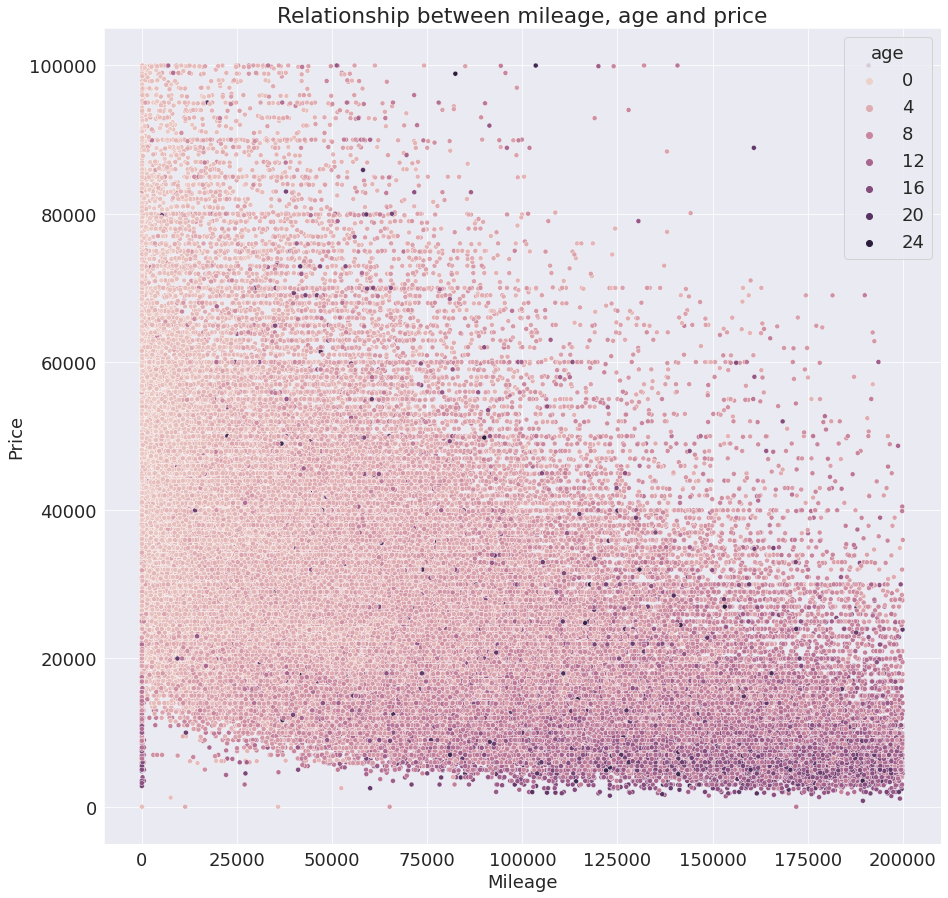

In [20]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price',x='miles', hue = 'age',data =canada_ds,s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

In general, expensive cars are either recent or have lower mileage. There are some exceptions (consider the dark points) where some old cars can hold a high value, regardless of the mileage.  
The following graphs show the most and the least expensive car makes in the market.

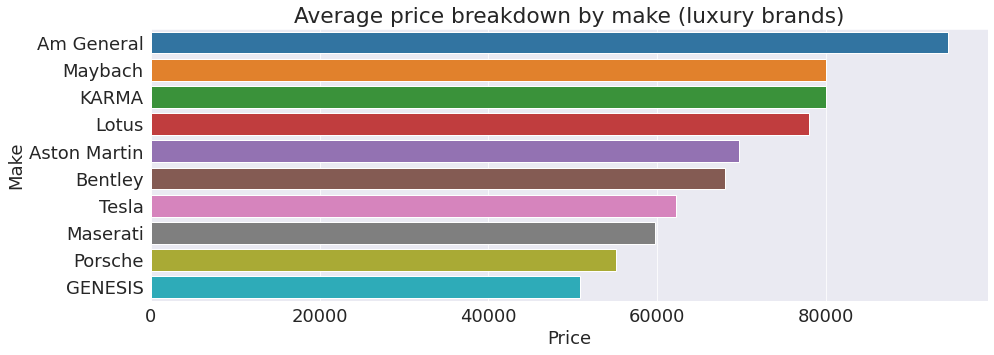

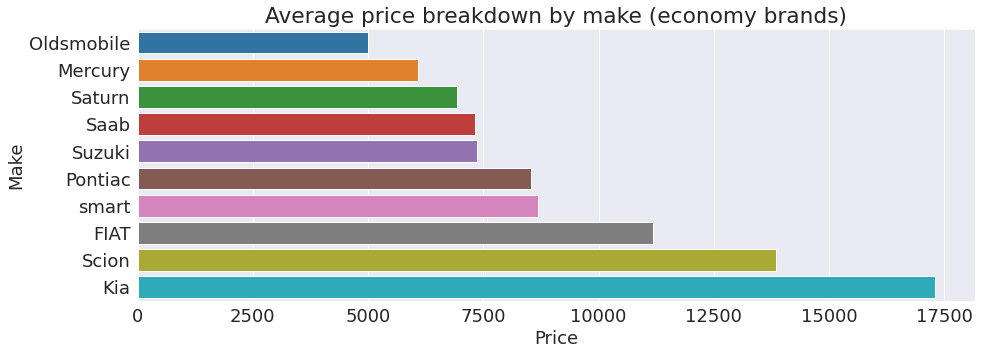

In [21]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Many electric car brands are in the top-10 most expensive cars. This is mainly due to their recent appearance in the market.  
Let's explore which drivetrain is more common in Canada.

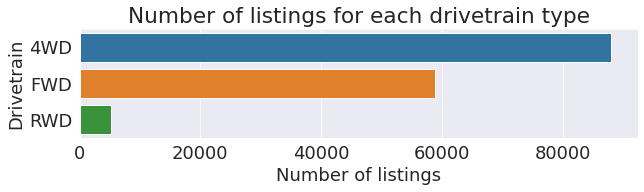

In [22]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

With no surprise, `4wd` cars are very common in Canada, due to its famously harsh winter!  
Next, we show the ratio of `Automatic` transmissions in the canadian market.

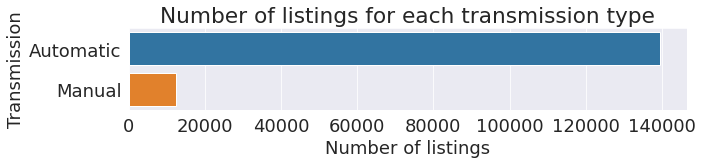

In [23]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'transmission'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Transmission', title = 'Number of listings for each transmission type');

In some provinces, used vehicles are more expensive due to the cost of living, taxes, and emission control. This is shown in the next graph.

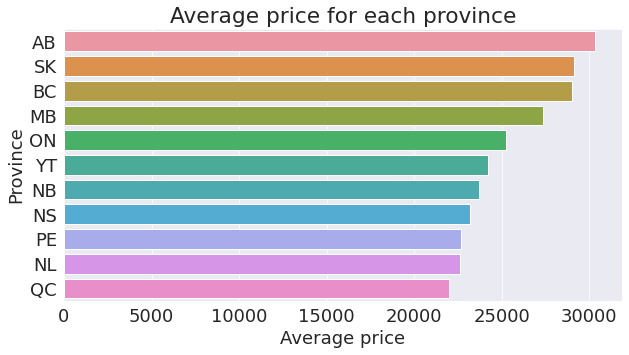

In [24]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'Province', title = 'Average price for each province');

The market share of each province is directly related to its population size. As shown on the next plot, Ontario has the highest number of listings (and the largest population).

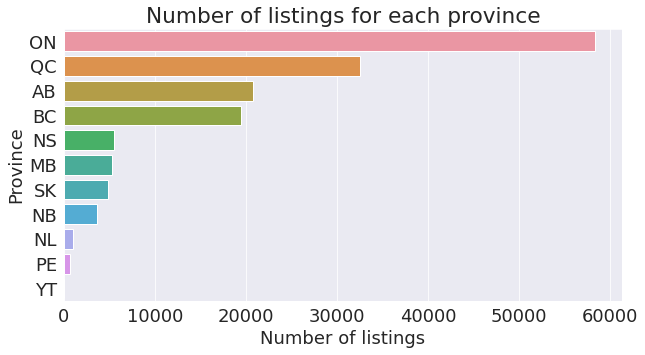

In [25]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Province', title = 'Number of listings for each province');

In [26]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

## 3- Prepare data for machine learning

After cleaning the data, we select the most suitable features to predict/evaluate a used car price. Here is a list of available features in the dataframe: 

In [27]:
canada_ds.columns

Index(['vin', 'price', 'miles', 'year', 'make', 'model', 'trim', 'body_type',
       'vehicle_type', 'drivetrain', 'transmission', 'city', 'state', 'age'],
      dtype='object')

The output of our model will be obviously the **price**. We will not use the **VIN** number, and split the remaining features into two classes: numeric and categorical columns.  
Note that an important piece of information is missing here: **the car condition**. In the used car market, two very identical vehicles can have large price differences due to previous maintenance, accident history, rust, and interior condition. This detail will affect the precision of the prediction process.

In [28]:
target_cols = ['price']
features_num_cols = ['miles', 'age',]
features_cat_cols = ['make', 'model', 'drivetrain', 'transmission','state', 'city','trim','body_type','vehicle_type']

In [29]:
raw_data = canada_ds[features_num_cols+features_cat_cols+target_cols].copy()
avg_price = raw_data['price'].mean()
print('Average price is ${:.2f}'.format(avg_price))

Average price is $25771.99


The model output (*price*), has an average of $25k. The performance metrics of the regressions will be evaluated by comparison to this baseline value.

First, we split the data into training, validation and testing sets.

In [30]:
# split train, test and val
# remove annoying warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(raw_data, test_size = 0.2)
train_data, val_data = train_test_split(trainval_data, test_size = 0.25)

The numeric features will be scaled using *scikit learn* minmax scaler.

In [31]:
# normalize numeric inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(raw_data[features_num_cols])
train_data[features_num_cols] = scaler.transform(train_data[features_num_cols])
test_data[features_num_cols] = scaler.transform(test_data[features_num_cols])
val_data[features_num_cols] = scaler.transform(val_data[features_num_cols])


The categorical features will be transformed via a one hot encoding strategy.

In [32]:
# one hot encoding categorical inputs
from sklearn.preprocessing import OneHotEncoder
# the global encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_data[features_cat_cols])
new_one_hot_cols = [] #list(encoder.get_feature_names(features_cat_cols))
# I have to split the process into multiple parts to manage memory usage ... (unless you have collab pro)
for column in tqdm(features_cat_cols):
  encoder_i = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_data[[column]])
  new_one_hot_cols_i = list(encoder_i.get_feature_names([column]))
  train_data[new_one_hot_cols_i] = encoder_i.transform(train_data[[column]])
  test_data[new_one_hot_cols_i] = encoder_i.transform(test_data[[column]])
  val_data[new_one_hot_cols_i] = encoder_i.transform(val_data[[column]])
  new_one_hot_cols += new_one_hot_cols_i

These transformations create new features. Here is the total number of features.

In [33]:
print('number of features ={}'.format(len(features_num_cols + new_one_hot_cols)))

number of features =2810


The last step will be to create input and output dataframes for each set.

In [34]:
# create input and output dataframes
train_inputs = train_data[features_num_cols + new_one_hot_cols]
test_inputs = test_data[features_num_cols + new_one_hot_cols]
val_inputs = val_data[features_num_cols + new_one_hot_cols]

train_output = train_data[target_cols]
test_output = test_data[target_cols]
val_output = val_data[target_cols]

In [35]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

## 4- Predicting the price using machine learning 

In this part, we will train and tune various machine learning regression algorithms. The first method is based on gradient boosting, using the library **XGBoost**.

### 4-1 Regression using XGBoost

In [ ]:
# import XGBoost 
from xgboost import XGBRegressor 

**XGBoost** has multiple hyperparameters. In this notebook, we will tune two parameters:
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- n_estimators: Number of trees. A high number of trees will most likely lead to overfitting.  

We will use a grid search method to find the optimal values of these hyperparameters.  
The next cells request large memory amount, which is not an option with Google Colab (free version). I have done the computations on my local machine, and imported the files with the notebook in order to save time.  

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
results=[]
for max_depth in tqdm(range(5,11)):
    for n_estimators in tqdm(range(50,601,50)):
        model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        model.fit(train_inputs, train_output)
        train_preds = model.predict(train_inputs)
        val_preds = model.predict(val_inputs)
        error_train = mean_squared_error(train_output, train_preds, squared=False)
        error_val = mean_squared_error(val_output, val_preds, squared=False)
        print('max_depth={} **'.format(max_depth),'n_estimators={} **'.format(n_estimators),"RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))
        results.append([max_depth,n_estimators,error_train, error_val])

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
# save the results
with open('XGB_models.txt','wb') as fp:
    pickle.dump(results, fp)

In [36]:
# This cell is used to import files from a local machine 
#  run  this cell after you download XGB_models.txt (attached to the notebook)

from google.colab import files
uploaded = files.upload() 

Saving XGB_models.txt to XGB_models.txt


In [ ]:
# read results from pickle file if already exists
with open('XGB_models.txt','rb') as fp:
    results = pickle.load(fp)

The optimal values of `n_estimators` and `max_depth` are found by minimizing the validation error.

In [ ]:
val_errors = [results[i][3] for i in range(len(results))]
ind_opt = np.argmin(val_errors)
print('Minimum val_error={:.2f} with n_estimators={} and max_depth={}'.format(results[ind_opt][3],results[ind_opt][1],results[ind_opt][0]))

Minimum val_error=3255.39 with n_estimators=600 and max_depth=10


In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
# compute the optimal model if not already saved
model_opt = XGBRegressor(n_estimators=results[ind_opt][1], max_depth = results[ind_opt][0])
model_opt.fit(train_inputs,train_output)

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
# save xgbmodel
model_opt.save_model('XGB_opt.txt')

In [37]:
# This cell is used to import files from a local machine 
#  run  this cell after you download XGB_opt.txt (attached to the notebook)

from google.colab import files
uploaded = files.upload() 

Saving XGB_opt.txt to XGB_opt.txt


In [ ]:
# load model if already saved
model_opt = XGBRegressor()
model_opt.load_model('XGB_opt.txt')


We compare the average validation error value to the average output value:

In [ ]:
val_preds = model_opt.predict(val_inputs)
error_val = mean_squared_error(val_output, val_preds, squared=False)
print('Percentage validation error={:.2f}%'.format(100*error_val/avg_price))

Percentage validation error=9.43%


less than 10% error, considering that the model doesn't include any information about the condition of the vehicle, is a reasonable precision score. Let's evaluate the optimal model on the test set.

In [ ]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

Percentage test error=8.98%


The average accuracy here is close to 91% on the test data.  
Let's test our prediction algorithm on a sample. This data comes from an actual transaction, where a friend purchased a used 2010 **Lexus** **RX350** on May 2021, for 15000$, it had 150000km. This sample transaction was not reported in the dataset. 

In [ ]:
# 'miles', 'age', 'make', 'model', 'drivetrain', 'transmission', 'state','city', 'trim', 'body_type', 'vehicle_type', 'price'
my_car = [150000/1.6,12,'Lexus','RX','4WD','Automatic','QC','Pointe-claire','350','SUV','Truck',15000]
sample = pd.DataFrame(columns=raw_data.columns)
sample.loc[0] = my_car
print(sample)

sample[features_num_cols] = scaler.transform(sample[features_num_cols])
sample[new_one_hot_cols] = encoder.transform(sample[features_cat_cols])
sample_inputs = sample[features_num_cols + new_one_hot_cols]
sample_output = sample[target_cols]
sample_prediction = model_opt.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],sample_prediction[0]))

     miles age   make model  ... trim body_type vehicle_type  price
0  93750.0  12  Lexus    RX  ...  350       SUV        Truck  15000

[1 rows x 12 columns]
listing price=15000.00  /  predicted price=15760.50


The prediction is very close to the price, the prediction error is close to 5%. **XGBoost** regression is showing a very good performance. 

In [ ]:
jovian.commit(files=['XGB_opt.txt', 'XGB_models.txt'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional files...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

### 4-2 Regression using ElasticNet

In this section, the linear regression with combined L1 and L2 regularization is implemented. The tuning will select the optimal values of the following hyperparameters:
- `alpha`: A constant that multiplies the penalty terms. It increases or decreases the penalty of both regularizations.
- `l1_ratio`: The ratio of L1/L2 regularization terms.  
  
The same **grid search** approach will be used to find the best parameters. 

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
results=[]
for alpha in tqdm([1e-7,1e-6,1e-5,1e-4,1e-3]):
    for l1_ratio in tqdm([0,0.2,0.4,0.6,0.8,1]):
        model = ElasticNet(alpha = alpha, l1_ratio=l1_ratio)
        model.fit(train_inputs, train_output)
        train_preds = model.predict(train_inputs)
        val_preds = model.predict(val_inputs)
        error_train = mean_squared_error(train_output, train_preds, squared=False)
        error_val = mean_squared_error(val_output, val_preds, squared=False)
        print('alpha={} **'.format(alpha),'l1_ratio={} **'.format(l1_ratio),"RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))
        results.append([alpha,l1_ratio,error_train, error_val])

In [ ]:
# execute only on local machine or colab pro, if not available, skip this cell
with open('elasticnet_models.txt','wb') as fp:
    pickle.dump(results, fp)

In [38]:
# This cell is used to import files from a local machine 
#  run  this cell after you download elasticnet_models.txt (attached to the notebook)

from google.colab import files
uploaded = files.upload() 

Saving elasticnet_models.txt to elasticnet_models.txt


In [ ]:
# read results from pickle file if already exists
with open('elasticnet_models.txt','rb') as fp:
    results = pickle.load(fp)

In [ ]:
val_errors = [results[i][3] for i in range(len(results))]
ind_opt = np.argmin(val_errors)
print('Minimum val_error={:.2f} with alpha={} and l1_ratio={}'.format(results[ind_opt][3],results[ind_opt][0],results[ind_opt][1]))
model_opt = ElasticNet(alpha=results[ind_opt][0], l1_ratio=results[ind_opt][1])
model_opt.fit(train_inputs,train_output)

Minimum val_error=4444.40 with alpha=1e-05 and l1_ratio=0.8


ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.8,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
val_preds = model_opt.predict(val_inputs)
error_val = mean_squared_error(val_output, val_preds, squared=False)
print('Percentage validation error={:.2f}%'.format(100*error_val/avg_price))

Percentage validation error=17.86%


The percentage error here is higher than **XGBoost** (almost 2x). This algorithm shows a lower performance while being much simpler to implement. A similar performance is achieved on the test set.

In [ ]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

Percentage test error=17.58%


A last verification is to check the prediction on the *real world* sample transaction.

In [ ]:
# 'miles', 'age', 'make', 'model', 'drivetrain', 'transmission', 'state','city', 'trim', 'body_type', 'vehicle_type', 'price'
my_car = [150000,12,'Lexus','RX','4WD','Automatic','QC','Pointe-claire','350','SUV','Truck',15000]
sample = pd.DataFrame(columns=raw_data.columns)
sample.loc[0] = my_car
print(sample)

sample[features_num_cols] = scaler.transform(sample[features_num_cols])
sample[new_one_hot_cols] = encoder.transform(sample[features_cat_cols])
sample_inputs = sample[features_num_cols + new_one_hot_cols]
sample_output = sample[target_cols]
sample_prediction = model_opt.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],sample_prediction[0]))

    miles age   make model  ... trim body_type vehicle_type  price
0  150000  12  Lexus    RX  ...  350       SUV        Truck  15000

[1 rows x 12 columns]
listing price=15000.00  /  predicted price=22117.24


The difference between the prediction and the real price is high. By looking at the `RMS_error_train` values, it is clear that this algorithm is underfitting the data. It appears that the problem we are solving here is non-linear, so linear methods can not perform well. One method that is suitable for such problems is the use of **neural networks**. 

In [ ]:
jovian.commit(files=['XGB_opt.txt', 'XGB_models.txt','elasticnet_models.txt'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional files...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'

### 4-3 Regression using a Feedforward neural network

In this section, a feedforward neural network is implemented using the API **Keras**, which is based on **Tensorflow** developped and maintained by Google.  
For this implementation, we choose a simple architecture with fully connected hidden layers of 2000 neurons. Early stopping callback will be used to prevent overfitting. No hyperparameter tuning will be performed in this notebook as it is not in the scope of this project.

In [43]:
#from keras import models
from keras import models, layers
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)

In [ ]:
# This cell will run faster if GPU is activated, or in a local machine with NVIDIA and cuda installed
network1 = models.Sequential()
network1.add(layers.Dense(2000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network1.add(layers.Dense(2000 , activation='relu' )) 
network1.add(layers.Dense(2000 , activation='relu' )) 
network1.add(layers.Dense(1)) 
network1.compile(optimizer='adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])
# Training 
n_epochs =10000 # the maximum number of epochs
result1 = network1.fit(train_inputs, train_output,epochs = n_epochs,verbose=2, batch_size = 5000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

Epoch 1/10000
19/19 - 22s - loss: 854137728.0000 - root_mean_squared_error: 29225.6348 - val_loss: 630174912.0000 - val_root_mean_squared_error: 25103.2852
Epoch 2/10000
19/19 - 4s - loss: 335503072.0000 - root_mean_squared_error: 18316.7422 - val_loss: 177448800.0000 - val_root_mean_squared_error: 13320.9912
Epoch 3/10000
19/19 - 4s - loss: 152965616.0000 - root_mean_squared_error: 12367.9268 - val_loss: 121148280.0000 - val_root_mean_squared_error: 11006.7383
Epoch 4/10000
19/19 - 4s - loss: 104128968.0000 - root_mean_squared_error: 10204.3604 - val_loss: 90488952.0000 - val_root_mean_squared_error: 9512.5684
Epoch 5/10000
19/19 - 4s - loss: 80606392.0000 - root_mean_squared_error: 8978.1064 - val_loss: 71669040.0000 - val_root_mean_squared_error: 8465.7568
Epoch 6/10000
19/19 - 4s - loss: 64018884.0000 - root_mean_squared_error: 8001.1802 - val_loss: 57940724.0000 - val_root_mean_squared_error: 7611.8804
Epoch 7/10000
19/19 - 4s - loss: 51635176.0000 - root_mean_squared_error: 7185.

After the training, we plot the `RMSE` values for training and validation dataset for each epoch.

In [ ]:
val_err = result1.history['val_root_mean_squared_error']
train_err = result1.history['root_mean_squared_error']
fig = sns.lineplot(range(len(val_err)),val_err, label='Validation RMSE');
fig = sns.lineplot(range(len(train_err)),train_err, label='Training RMSE');
fig.set(xlabel = 'Number of epochs', ylabel = 'Root mean square error', title = 'RMSE training and validation data');

Let's see how the network performs on unseen data (test data).

In [ ]:
test_preds = network1.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

We obtain a good performance.**XGBoost** shows a better performance, but cannot compare to the neural net at this stage. We need to perform hyperparameter optimization prior to any comparison (architecture, optimizer, activation functions, etc). This will be detailled in a future work. Neural networks can be very efficient when applied to large complex and non-linear systems. Here is the prediction on the `sample` we used previously.

In [ ]:
# 'miles', 'age', 'make', 'model', 'drivetrain', 'transmission', 'state','city', 'trim', 'body_type', 'vehicle_type', 'price'
my_car = [150000/1.6,12,'Lexus','RX','4WD','Automatic','QC','Pointe-claire','350','SUV','Truck',15000]
sample = pd.DataFrame(columns=raw_data.columns)
sample.loc[0] = my_car
print(sample)

sample[features_num_cols] = scaler.transform(sample[features_num_cols])
sample[new_one_hot_cols] = encoder.transform(sample[features_cat_cols])
sample_inputs = sample[features_num_cols + new_one_hot_cols]
sample_output = sample[target_cols]
NN_sample_prediction = network1.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],NN_sample_prediction[0][0]))

The error is less than 8%. Not bad, considering no tuning was done!

In [ ]:
jovian.commit(files=['XGB_opt.txt', 'XGB_models.txt','elasticnet_models.txt'])

## 5- Conclusion and future work

In this project, three machine learning algorithms for used cars price prediction were designed. After conducting an exploratory analysis on data from the canadian used cars market (from Kaggle), we chose and engineered the features used to develop:
- An **XGBoost** regression algorithm, where hyperparameters `max_depth` and `n_estimators` were tuned.
- An **ElasticNet** regression, with `l1_ratio` and `alpha` optimization.
- A feedforward neural network regression, with three hidden layers.  
  
Both **XGboost** and neutral network showed a reasonable performance. Our models didn't take into account the condition of the cars (mechanical and cosmetic), beacause it was missing form the data. This issue has nevertheless been compensated by the ability of algorithms to generalize. **ElasticNet** technique wasn't able to reach error levels comparable to **XGboost** and neural nets. This can be related to the non-linear nature of the problem.  

The next step will be to apply the same approach to the US market. The dataset is larger, and has more categories. The neural network will be improved by selecting different architectures, optimizers and activation functions.

In [ ]:
jovian.commit(files=['XGB_opt.txt', 'XGB_models.txt','elasticnet_models.txt'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional files...
Committed successfully! https://jovian.ai/kara-mounir/used-cars-prices


'https://jovian.ai/kara-mounir/used-cars-prices'